# Les forêts aléatoires & leurs estimateurs à noyaux
**Contributeurs :** *Laure Ferraris, Paul Liautaud*

Ce notebook est dédié à l'implémentation et à l'évaluation de performances de différentes forêts aléatoires (alias RF) vues au fil du cours, à savoir :
- les RF de Breiman ;
- les RF centrées.

$\hookrightarrow$ *Le but sera également d'implémenter les estimateurs KeRF associés, souvent fournissant de meilleures estimations au regard des RF classiques.*

Dans toute la suite et de façon générale (sauf spécification), on considère un jeu de données $\mathcal{D}_n = (\mathbf{X}_i, Y_i)_{1 \leq i \leq n}$, comme établi sur le polycopié associé. 

Commençons par quelques lignes de codes nécessaires, avec l'implémentation de $2$ fonctions d'erreur quadratique (erreur $L^2$) :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

def MSE(pred, Y):
    return(np.mean((pred-Y)**2))

def MSE_MC(Pred, Y):
    Err = []
    for ele in Pred:
        Err.append(np.mean((ele-Y)**2))
    return(Err)

## Arbres et forêts aléatoires centrés

### L'arbre centré :

On réfère au cours associé pour comprendre la construction de cet arbre. Une proposition d'implémentation pour un arbre centré `Centred_Tree` qui prend en arguments $2$ matrices d'observations `X_target`,`X_train` et le niveau $k$ de l'arbre :

In [2]:
def Centred_Tree(X_target, X_train, k):
    ''' About input : Matrix of X_target (BE CAREFULL it doesn't work for a single vector.)
        Return : List (length of X_target.shape[0]) of list of indexes (indicating data connected to x_target).
        More info : we don't set the seed here as it will be done in the centred forest
    '''
    N = X_train.shape[0]
    d = X_train.shape[1]
    I   = np.random.randint(0, d, size = k)
    K_j = [(I == d_i).sum() for d_i in np.arange(d)]
    IDX = [] 
    for x in X_target:
        Idx = []
        for n in np.arange(N):
            x_train    = X_train[n]
            i          = 0
            while True: 
                crit_train = np.ceil(x_train[i]*2**K_j[i])
                crit       = np.ceil(x[i]*2**K_j[i])
                if crit_train != crit :
                    break
                i += 1
                if i == d:
                    Idx.append(n)
                    break
        IDX.append(Idx)
    return IDX

On en déduit une prédiction par forêt aléatoire, à $M$ arbres centrés de niveau $k$ sur un jeu de données (`X_train`, `Y_train`) $\in [0;1]^{n \times d} \times \mathbb{R}^n$ :

In [3]:
def Centred_Forest(X_target, X_train, k, M, bootstrap = False, max_samples = None, seed=0):   
    np.random.seed(seed) #seed to compare RF and KeRF performances
    IDX = []
    for m in np.arange(M):
        IDX.append([])
    #Boostrapping
        if bootstrap == True and max_samples == None:
            I_train  = np.random.choice(np.arange(X_train.shape[0]), size = X_train.shape[0])
            S_train  = X_train[I_train]
        elif type(max_samples) == int:
            if max_samples == 0:
                I_train  = np.arange(X_train.shape[0])
                S_train  = X_train
            else:   
                I_train  = np.random.choice(np.arange(X_train.shape[0]), size = max_samples)
                S_train  = X_train[I_train]
        elif type(max_samples) == float:
            I_train  = np.random.choice(np.arange(X_train.shape[0]), size = int(max_samples * X_train.shape[0]))
            S_train  = X_train[I_train]
        elif bootstrap == False:
            I_train  = np.arange(X_train.shape[0])
            S_train  = X_train
            
    #Construction of the Tree
        Idx = Centred_Tree(X_target, S_train, k) #Idx : LIST of list of indexes
        for ele in Idx:
             IDX[-1].append(list(I_train[ele]))#convertion of indexes from S_train to X_train
    return(IDX)#IDX : LIST of list of list of indexes: shape(np_trees, X_target.shape[0])

### Estimateurs RF centrée et KeRF centré

On construit ici les fonctions *estimateurs forêt* et *estimateur forêt à noyau* à partir de la même forêt dans les $2$ cas, et en utilisant la fonction `Centred_Forest`.
Voici les $2$ fonctions estimatrices (`Centred_RFreg` vs `Centred_KeRFreg`) de la fonction de régression :

In [4]:
def Centred_RFreg(I, Y_train):
    '''
    I is a list(m_tree) of list(X_target.shape[0]) : seen as the forest
    of a list(idx of data connected to x_target) returned by Centred_Forest
    '''
    RF = []
    for IDX in I:
        RF.append([])
        for Idx in IDX:
            if len(Idx) == 0:
                RF[-1].append(0) #by convention, for each tree if the cell of x is empty, tree's estimation is set to 0
            else:
                RF[-1].append(np.sum(Y_train[Idx]) / len(Idx))  
    Pred_RFCentred = np.mean(RF, axis=0)
    return(Pred_RFCentred)

def Centred_KeRFreg(I, Y_train):
    '''
    I is a list(m_tree) of list(X_target.shape[0]) : seen as forest 
    of a list(idx of data connected to x_target) returned by Centred_Forest
    '''
    Pred_KeRFCentred = []
    Sum_Y = np.zeros(len(I[0]))
    Sum_N = np.zeros(len(I[0]))
    for IDX in I:
        for l, Idx in enumerate(IDX):
            if len(Idx) == 0:
                continue
            else:
                Sum_Y[l] += np.sum(Y_train[Idx])
                Sum_N[l] += len(Idx)
            
    for l in np.arange(len(Sum_N)):
        if Sum_N[l]==0:
            Pred_KeRFCentred.append(0)
        else:
            Pred_KeRFCentred.append(Sum_Y[l]/Sum_N[l])
    Pred_KeRFCentred = np.array(Pred_KeRFCentred)
    return(Pred_KeRFCentred)

# Étude et comparaison des estimateurs centrés sur 2 modèles

On considère des v.a. multivariées $\mathbf X = (X_1,...,X_d)$ uniformément distribuées sur $[0,1]^d$ et la transformation linéaire $\tilde{ \mathbf X} = 2 \mathbf X - \mathbb 1,$ où $\mathbb 1 = (1,\dots, 1)\in \mathbb R^d$.

Pour comparer les performances de chaque estimateur, nous nous baseront sur les $2$ modèles suivants :
- *Modèle 1*:  $n=800$, $d=2$, $Y= \tilde{X}_1^2+\exp(-\tilde{X}_2^2)$;
- *Modèle 2*: $n=600$, $d=100$, $Y=\tilde{X}_1\tilde{X}_2 + \tilde{X}_3^2 - \tilde{X}_4\tilde{X}_7 + \tilde{X}_8\tilde{X}_{10} - \tilde{X}_6^2 + \mathcal{N}(0,0.5)$.

## Modèle 1

In [5]:
#Fixation de la seed
np.random.seed(1)

#Paramètres du modèle
N = 800
d = 2

#Données
X = np.random.rand(N, d)
X_tild  = 2*X - 1
Y = 2*(X_tild[:,0]) + np.exp(-(X_tild[:,1]**2)) 

#Découpage données
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#Paramètres de la forêt
k   = int(np.log2(N))
M_tree = np.r_[1, 50, np.arange(100, 510, 100)]
MTREE   = 500

### Construction de la forêt centrée et des estimateurs

Notez que la prochaine cellule peut prendre un peu de temps...

In [6]:
#Construction de la forêt sur les données d'entraînement
I1 = Centred_Forest(X_test, X_train, k, MTREE)  #Model 1

In [7]:
#Calcul de l'estimateur RF sur la forêt I1
Pred_RFCentred1 = []
for m in M_tree:
    Pred_RFCentred1.append(Centred_RFreg(I1[:m], Y_train))
Err_RFCentred1 = MSE_MC(Pred_RFCentred1, Y_test)   

#Calcul de l'estimateur KeRF sur la forêt I1
Pred_KeRFCentred1 = []
for m in M_tree:
    Pred_KeRFCentred1.append(Centred_KeRFreg(I1[:m], Y_train))
Err_KeRFCentred1 = MSE_MC(Pred_KeRFCentred1, Y_test)

### Comparaison avec l'estimation de Breiman

In [8]:
#Calcul de l'estimateur RF Breiman sur la forêt I1
pred_RFBreiman1 = []
for M in M_tree:
    reg = RandomForestRegressor(n_estimators=M, max_features=0.333, bootstrap=False, random_state=0)
    reg.fit(X_train, Y_train)
    pred_RFBreiman1.append(reg.predict(X_test))
Err_BreimRF1 = MSE_MC(pred_RFBreiman1, Y_test)

### Erreur $L^2$ pour le modèle 1

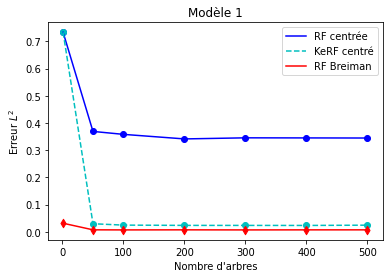

In [29]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(M_tree, Err_RFCentred1, "b", label='RF centrée')
ax.scatter(M_tree, Err_RFCentred1, color="b")
ax.plot(M_tree, Err_KeRFCentred1, '--c', label='KeRF centré')
ax.scatter(M_tree, Err_KeRFCentred1, color="c")
ax.plot(M_tree, Err_BreimRF1, "r", label='RF Breiman')
ax.scatter(M_tree, Err_BreimRF1, color="r", marker="d")
ax.set_xlabel("Nombre d'arbres")
ax.set_ylabel(r'Erreur $L^2$')
ax.set_title('Modèle 1')
ax.legend()

## Modèle 2

In [10]:
#Fixation de la seed
np.random.seed(1)

#Paramètres du modèle
N = 600
d = 100

#Données
X = np.random.rand(N, d)
X_tild  = 2*X - 1
Y = X_tild[:,0]*X_tild[:,1] + X_tild[:,2]**2 - X_tild[:,3]*X_tild[:,6] + X_tild[:,7]*X_tild[:,9] - X_tild[:,5]**2 + np.sqrt(0.5)*np.random.randn(N)

#Découpage données
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X, Y, test_size=0.2, random_state=42)

#Paramètres de la forêt
k   = int(np.log2(N))
M_tree = np.r_[1, 50, np.arange(100, 510, 100)]
MTREE   = 500

### Construction de la forêt centrée et des estimateurs

Notez que l'exécution la prochaine cellule peut prendre un peu de temps...

In [11]:
#Construction de la forêt sur les données d'entraînement
I2 = Centred_Forest(X_test_2, X_train_2, k, MTREE)  #Model 1

In [12]:
#Calcul de l'estimateur RF sur la forêt I2
Pred_RFCentred2 = []
for m in M_tree:
    Pred_RFCentred2.append(Centred_RFreg(I2[:m], Y_train_2))
Err_RFCentred2 = MSE_MC(Pred_RFCentred2, Y_test_2)   

#Calcul de l'estimateur KeRF sur la forêt I2
Pred_KeRFCentred2 = []
for m in M_tree:
    Pred_KeRFCentred2.append(Centred_KeRFreg(I2[:m], Y_train_2))
Err_KeRFCentred2 = MSE_MC(Pred_KeRFCentred2, Y_test_2)

### Comparaison avec l'estimation de Breiman

In [13]:
#Calcul de l'estimateur RF Breiman sur la forêt I1
pred_RFBreiman2 = []
for M in M_tree:
    reg = RandomForestRegressor(n_estimators=M, max_features=0.333, bootstrap=False, random_state=0)
    reg.fit(X_train_2, Y_train_2)
    pred_RFBreiman2.append(reg.predict(X_test_2))
Err_BreimRF2 = MSE_MC(pred_RFBreiman2, Y_test_2)

### Erreur $L^2$ pour le modèle 2

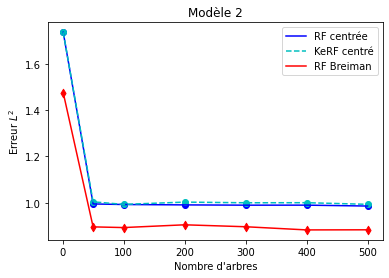

In [30]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(M_tree, Err_RFCentred2, "b", label='RF centrée')
ax.scatter(M_tree, Err_RFCentred2, color="b")
ax.plot(M_tree, Err_KeRFCentred2, '--c', label='KeRF centré')
ax.scatter(M_tree, Err_KeRFCentred2, color="c")
ax.plot(M_tree, Err_BreimRF2, "r", label='RF Breiman')
ax.scatter(M_tree, Err_BreimRF2, color="r", marker="d")
ax.set_xlabel("Nombre d'arbres")
ax.set_ylabel(r'Erreur $L^2$')
ax.set_title('Modèle 2')
ax.legend()

# Illustration des arbres en dimension $d=2$

On considère $n = 200$ données aléatoires et multivariées de dimension $d=2$, telles que chaque donnée est telle que $\mathbf X = (X_1,X_2)$ uniformément distribuées sur $[0,1]^2$.  

On définit $\tilde{\mathbf X} \in \mathbb{R}^2$ tel que $\forall 1 \leq i \leq n$, $$\tilde{X_i} = 2(X_i - 0.5).$$
Et on pose $$Y = \tilde{X_1}^2 + \exp\left(-\tilde{X_2}^2\right).$$  
Pour l'expérience, l'échantillon est divisé en un jeu d'entraînement ($80\%$) et de test ($20\%$).

In [15]:
#Fixation seed
np.random.seed(1)

#Paramètres et définition du modèle
N = 200
d = 2
X = np.random.rand(N, d)
X_tild  = 2*X - 1
Y = 2*(X_tild[:,0]) + np.exp(-(X_tild[:,1]**2)) 
k= int(np.log2(N))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Illustration avec des arbres centrés

In [16]:
X_target = X_test[:4,:]
np.random.seed(0)
IDX = Centred_Tree(X_target, X_train, k)

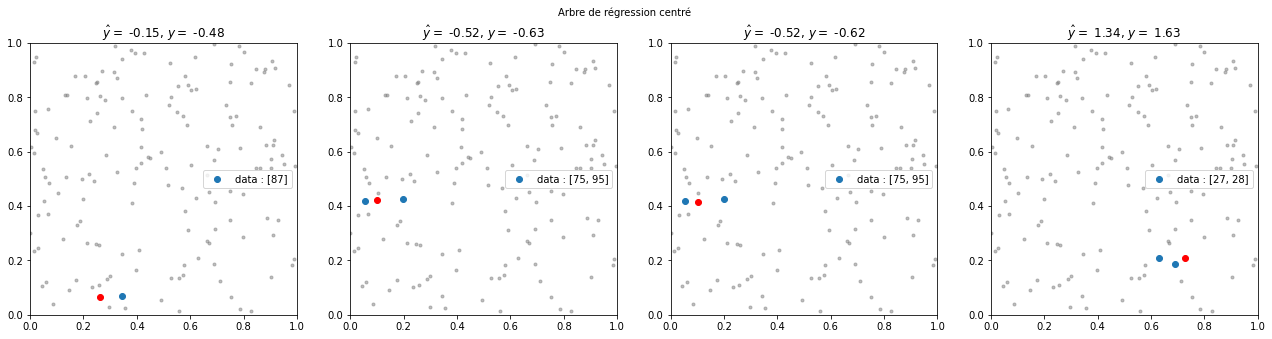

In [17]:
#Configuration de la figure
gs = GridSpec(1, 4)  # 1 row, 4 columns
fig = plt.figure(figsize=(22, 5))
ax = [fig.add_subplot(pos) for pos in [gs[0, 0], gs[0, 1], gs[0, 2], gs[0, 3]]]

#Plots
for i, Idx in enumerate(IDX):
    if len(Idx)==0:
        pred = 0
    else:
        pred = np.sum(Y_train[Idx])/len(Idx)
    ax[i].scatter(X_train[:, 0], X_train[:, 1], color='grey', marker=".", alpha=0.5)
    ax[i].scatter(X_train[Idx, 0], X_train[Idx, 1], label=f"data : {Idx}")
    ax[i].set_xlim(0,1)
    ax[i].set_ylim(0,1)
    #ax[i].grid()
    ax[i].scatter(X_target[i, 0], X_target[i, 1], color='red')
    ax[i].legend(loc="best")
    ax[i].set_title(fr"$\hat y =$ {pred:.2f}, $y =$ {Y_test[i]:.2f}")
    
plt.suptitle("Arbre de régression centré", fontsize=10);

## Exemple pathologique

On se propose ici d'exposer le cas pathologique développé dans le polycopié de référence à ce notebook.

Nous gardons le même modèle mais l'utilisateur est maintenant invité à choisir manuellement un point $\mathbf x \in [0;1]^2$ pour y faire une estimation par **$M$ *arbres centrés***.

In [18]:
#Fixation seed
np.random.seed(1)

#Paramètres et définition du modèle
N = 200
d = 2
X = np.random.rand(N, d)
X_tild  = 2*X - 1
Y = 2*(X_tild[:,0]) + np.exp(-(X_tild[:,1]**2)) 
k= int(np.log2(N))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [19]:
#Choix du nombre d'arbres
M = 4

#Choix du point à estimer
x = np.array([.9,.6])

#Construction de M arbres décisionnels centrés pour prédire m(x)
x_tild = 2*x - 1
y_true = 2*(x_tild[0]) + np.exp(-(x_tild[1]**2)) 
N = X.shape[0]
d = X.shape[1]

INDEX = []
for m in np.arange(M):
    I   = np.random.randint(0, d, size = k)
    K_j = [(I == d_i).sum() for d_i in np.arange(d)]
    Ix = []
    for n in np.arange(N):
        x_train    = X[n]
        i          = 0
        while True: 
            crit_train = np.ceil(x_train[i]*2**K_j[i])
            crit       = np.ceil(x[i]*2**K_j[i])
            if crit_train != crit :
                break
            i += 1
            if i == d:
                Ix.append(n)
                break
    INDEX.append(Ix)

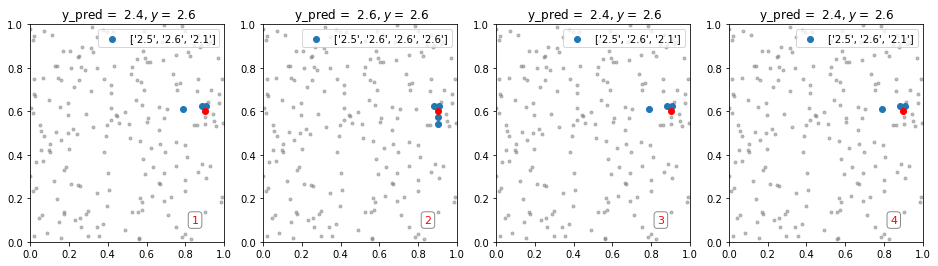

In [20]:
#Configuration fenêtre
gs = GridSpec(1, 4)  # 1 row, 4 columns
fig = plt.figure(figsize=(16, 4))
ax = [fig.add_subplot(pos) for pos in [gs[0, 0], gs[0, 1], gs[0, 2], gs[0, 3]]] 

#Prédiction
for i, Idx in enumerate(INDEX):
    if len(Idx)==0:
        pred = 0
    else:
        pred = np.sum(Y[Idx])/len(Idx)  
    y_vals = ["{:0.1f}".format(y) for y in Y[Idx]]
    ax[i].scatter(X[:, 0], X[:, 1], color='grey', marker=".", alpha=0.5)
    ax[i].scatter(X[Idx, 0], X[Idx, 1], label= y_vals)
    ax[i].set_xlim(0,1)
    ax[i].set_ylim(0,1)
    #ax[i].grid()
    ax[i].scatter(x[0], x[1], color='red')
    ax[i].legend(loc="upper right")
    ax[i].set_title(fr" y_pred =  {pred:.1f}, $y = $ {y_true:.1f}")
    bboxprops = dict(boxstyle="round", facecolor="white", edgecolor="0.5", alpha=0.9)
    ax[i].text(0.85, 0.1, f'{i+1}', horizontalalignment="center",
        verticalalignment="center", fontsize=11, color='red', bbox=bboxprops);

# -- Annexe --

Pour finir, on fournit du matériel de code pour les fans de forêts aléatoires souhaitant s'amuser à dessiner manuellement des figures d'arbres/partitionnement sur le plan :

In [21]:
x1 = np.linspace(0.1, 0.9, 20)
x2 = np.linspace(0.1, 0.9, 20)
i1 = [9, 10, 4, 0, 19, 6, 8, 7, 18, 17, 1, 3, 5, 16, 11, 13, 15, 14, 2, 12]
x1 = x1[i1]
Y = np.random.randint(0,100,20)
y_val = [str(y) for y in Y]

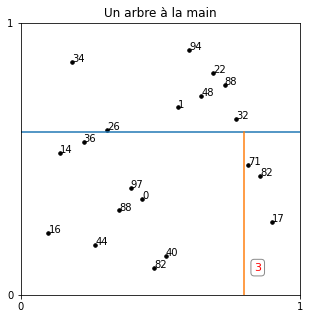

In [22]:
#Configuration figure
fig, ax = plt.subplots(figsize=(5,5))

#Plots
ax.plot(x1, x2, linestyle='', color='k', linewidth=2, marker='.', markersize=7)
for k in range(len(Y)):
    ax.text(x1[k], x2[k], y_val[k])
    
ax.set_xlim(0.0, 1.)  # Set x limits
ax.set_xticks([0, 1])
ax.set_ylim(0.0, 1)
ax.set_yticks([0,1]);
ax.plot([0, 1], [0.6, 0.6])
ax.plot([0.8,0.8], [0, 0.6])

ax.set_title("Un arbre à la main")

#Boxes pour la numérotation des cellules
bboxprops = dict(boxstyle="round", facecolor="white", edgecolor="0.5", alpha=0.9)
ax.text(0.85, 0.1, r'3', horizontalalignment="center",
        verticalalignment="center", fontsize=11, color='red', bbox=bboxprops);